In [1]:
import torch
import os
from l5kit.configs import load_config_data

from models.LyftNet.LyftNet import LyftNet, LyftLoss
from models.LyftNet.MNASBackbone import MnasBackbone
from models.resnet152.loss_functions import pytorch_neg_multi_log_likelihood_batch
from l5kit.evaluation import write_pred_csv

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.rasterization import build_rasterizer
from l5kit.dataset import AgentDataset
from models.LyftNet.Kinetic.KineticDataset import KineticDataset

from torch.utils.data import DataLoader

import os
import torch

from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np

import pandas as pd

data_path = "/home/michael/Workspace/Lyft/data/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = load_config_data("/home/michael/Workspace/Lyft/models/LyftNet/config_lyftnet.yaml")

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = data_path
dm = LocalDataManager(None)
# get config
cfg = config
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'lyft-net', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 75, 'shuffle': True, 'num_workers': 16}, 'test_data_loader': {'key': 'scenes/test.zarr', 'batch_size': 75, 'shuffle': False, 'num_workers': 32}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 1500, 'eval_every_n_steps': 10000}}


In [164]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
# train_zarr = ChunkedDataset(dm.require("scenes/sample.zarr")).open()
train_dataset = KineticDataset(cfg, train_zarr, rasterizer)


agents = pd.DataFrame.from_records(train_zarr.agents,
                                   columns=['centroid', 'extent', 'yaw', 'velocity', 'track_id',
                                            'label_probabilities'])
agents.set_index('track_id')
display(train_zarr.agents)

KeyboardInterrupt: 

In [ ]:
display(agents)

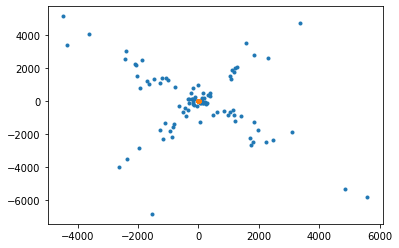

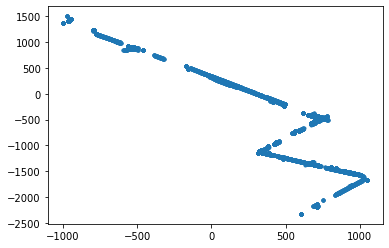

In [162]:
import numpy as np
import matplotlib.pyplot as plt
groupID = agents.drop("yaw", axis=1).drop("label_probabilities", axis=1).drop("extent", axis=1).groupby('track_id')
# for state, frame in groupID:
#      print(f"First 2 entries for {state!r}")
#      print("------------------------")
#      print(frame.head(2), end="\n\n")

vel_t = groupID.get_group(2)["velocity"]
pos = groupID.get_group(2)['centroid']

vel = (pos.iloc[:-1].values - pos.iloc[1:].values) / 0.1

def convert(vel):
    velx = []
    vely = []
    for velocity in vel:
        velx.append(velocity[0])
        vely.append(velocity[1])
    return velx, vely


velx, vely = convert(vel)

plt.plot(velx, vely, '.')

velx, vely = convert(vel_t)

plt.plot(velx, vely, '.')
plt.show()

posx, posy = convert(pos)

plt.plot(posx, posy, '.')

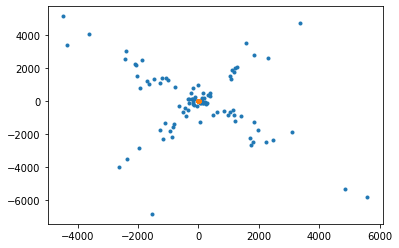

,centroid,velocity
,count,count
max,14922.000000,14922.000000
min,1.000000,1.000000
mean,743.516294,743.516294
std,942.354177,942.354177


,count,mean
track_id,,
1,14922,"[5.202215194702148, 5.646387577056885]"
2,12377,"[5.032926559448242, 5.223700046539307]"
3,10179,"[4.230915069580078, 4.482477188110352]"
4,8224,"[3.206543207168579, 4.166661739349365]"
5,9108,"[3.8044257164001465, 4.215086936950684]"
...,...,...
2543,2,"[0.0, 0.0]"
2544,1,"[0.0, 0.0]"
2545,1,"[0.0, 0.0]"


In [160]:
counts = groupID.agg(["count"])
display(counts.agg(["max", "min", "mean", "std"]))

groupID.agg(count=("centroid", lambda x: len(x)), mean=("velocity", lambda x: np.vstack(x).std(axis=0).tolist()))

In [143]:
717.6123657226562 -717.6612548828125

-0.04888916015625

In [36]:
pd.DataFrame.from_records(train_zarr.agents)

,0,1,2,3,4,5
0,"[665.0342407226562, -2207.51220703125]","[4.3913283, 1.8138304, 1.5909758]",1.016675,"[0.0, 0.0]",1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[717.6612548828125, -2173.760009765625]","[5.150925, 1.9530917, 2.04021]",-0.783224,"[0.0, 0.0]",2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[730.681396484375, -2180.678955078125]","[2.9482825, 1.4842174, 1.1125067]",-0.321747,"[0.0, 0.0]",3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[671.2536010742188, -2204.745361328125]","[1.7067024, 0.9287868, 0.6282158]",0.785501,"[0.0, 0.0]",4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[669.7763061523438, -2213.004638671875]","[0.25109944, 0.6343781, 1.654377]",1.492359,"[0.0, 0.0]",5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
1893731,"[278.2374267578125, 50.95383071899414]","[2.651326, 16.242971, 1.8459053]",0.728024,"[0.0, 0.0]",1478,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893732,"[321.0816345214844, 35.29806137084961]","[0.34564313, 0.7559242, 0.5863746]",0.582523,"[0.09659984, -0.23340665]",1479,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893733,"[227.16343688964844, 73.9880599975586]","[2.024245, 0.3544109, 0.8435698]",0.942606,"[-0.091657355, 3.9186544]",1481,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1893734,"[213.86314392089844, 75.33246612548828]","[0.51277804, 1.2809446, 1.1334285]",-0.809572,"[0.0, 0.0]",1483,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [44]:
display(train_dataset)

In [118]:
1874640/2

937320.0